In [33]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

import warnings

# Ignore warnings
warnings.filterwarnings("ignore")

In [9]:
import os
os.chdir("/config/workspace")

In [10]:
FILE_PATH =r"fertilizer-prediction/Fertilizer Prediction.csv"

# Loading the dataset into pandas
df = pd.read_csv(FILE_PATH)

df.head()

,Temparature,Humidity,Moisture,Soil Type,Crop Type,Nitrogen,Potassium,Phosphorous,Fertilizer Name
0,26,52,38,Sandy,Maize,37,0,0,Urea
1,29,52,45,Loamy,Sugarcane,12,0,36,DAP
2,34,65,62,Black,Cotton,7,9,30,14-35-14
3,32,62,34,Red,Tobacco,22,0,20,28-28
4,28,54,46,Clayey,Paddy,35,0,0,Urea


In [11]:
print(f"Shape of the dataset: {df.shape}")

Shape of the dataset: (99, 9)


In [12]:
# datatypes 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99 entries, 0 to 98
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Temparature      99 non-null     int64 
 1   Humidity         99 non-null     int64 
 2   Moisture         99 non-null     int64 
 3   Soil Type        99 non-null     object
 4   Crop Type        99 non-null     object
 5   Nitrogen         99 non-null     int64 
 6   Potassium        99 non-null     int64 
 7   Phosphorous      99 non-null     int64 
 8   Fertilizer Name  99 non-null     object
dtypes: int64(6), object(3)
memory usage: 7.1+ KB


In [13]:
# checking for null values 
df.isnull().sum()

Temparature        0
Humidity           0
Moisture           0
Soil Type          0
Crop Type          0
Nitrogen           0
Potassium          0
Phosphorous        0
Fertilizer Name    0
dtype: int64

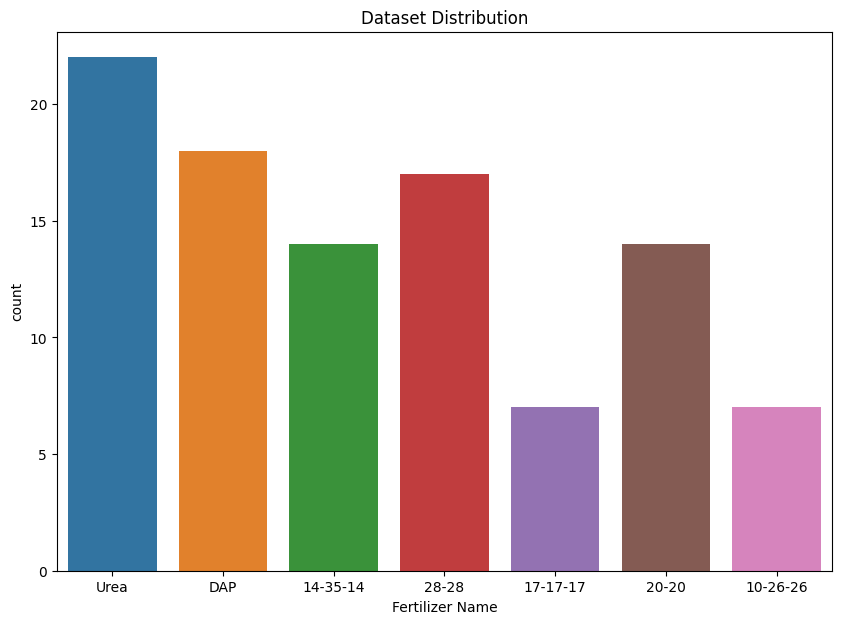

In [14]:
# checking the data distribution 
plt.figure(figsize=(10, 7))

sns.countplot(data=df, x='Fertilizer Name')
plt.title("Dataset Distribution")
plt.show()

In [15]:
# soil type
df['Soil Type'].unique()

array(['Sandy', 'Loamy', 'Black', 'Red', 'Clayey'], dtype=object)

In [16]:
df['Crop Type'].unique()

array(['Maize', 'Sugarcane', 'Cotton', 'Tobacco', 'Paddy', 'Barley',
       'Wheat', 'Millets', 'Oil seeds', 'Pulses', 'Ground Nuts'],
      dtype=object)

In [17]:
# splitting the dataset 
X = df.drop(columns=["Fertilizer Name"])
y = df["Fertilizer Name"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Shape of the training dataset: {X_train.shape}")
print(f"Shape of the testing dataset: {X_test.shape}")

Shape of the training dataset: (79, 8)
Shape of the testing dataset: (20, 8)


In [18]:
# segrating categorical columns
categorical_columns = [i for i in df.columns if (i not in df._get_numeric_data().columns) & (i !='Fertilizer Name')]
categorical_columns

['Soil Type', 'Crop Type']

## Encoding

In [21]:
ohe = OneHotEncoder(drop='first')
standard_scaler = StandardScaler()

preprocessor = ColumnTransformer(
    transformers =[
        ('StandaradScaling', standard_scaler, df._get_numeric_data().columns),
        ('One_hot_encoding', ohe, categorical_columns)
    ],
    remainder='passthrough'
)

pipeline = Pipeline([
    ('preprocess', preprocessor)
])

In [26]:
X_train_transformed = pipeline.fit_transform(X_train)
X_test_transformed = pipeline.transform(X_test)

In [27]:
le = LabelEncoder()

y_train_transformed = le.fit_transform(y_train)
y_test_transformed = le.transform(y_test)

In [28]:
def evaluate_clf(true, predicted):
    '''
    This function takes in true values and predicted values
    Returns: Accuracy, F1-Score, Precision, Recall, Roc-auc Score
    '''
    acc = accuracy_score(true, predicted)
    f1 = f1_score(true, predicted, average='weighted')
    precision = precision_score(true, predicted, average='weighted')
    recall = recall_score(true, predicted, average='weighted')
    
    return acc, f1, precision, recall

In [29]:
# create a function which can evaluate models and returns a report 
def evaluate_model(X_train, X_test, y_train, y_test, models):
    '''
    This function takes X_train, X_test, y_train, y_test  and models dictionary as input
    Iterate through the given model directory and evaluate metrics

    Returns:
    DataFrame which contains report of all models metrics 
    '''

    model_list = []
    metric_list = []

    for i in range(len(list(models))):
        model = list(models.values())[i]
        model.fit(X_train, y_train)

        # Make predictions
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        # Training set performances
        model_train_accuracy, model_train_f1, model_train_precision, \
            model_train_recall = evaluate_clf(y_train, y_train_pred)

        # Test set peformances 
        model_test_accuracy, model_test_f1, model_test_precision, \
            model_test_recall = evaluate_clf(y_test, y_test_pred)

        print(list(models.keys())[i])
        model_list.append(list(models.keys())[i])

        result_dict ={'model_name':list(models.keys())[i], 
                    "train_accuracy": model_train_accuracy, "test_accuracy": model_test_accuracy,
                    "train_precision": model_train_precision, "test_precision": model_test_precision,
                    'train_recall': model_train_recall, "test_recall":model_test_recall,
                    "train_f1_score": model_train_f1, "test_f1_score": model_test_f1}

        metric_list.append(result_dict)

    
    return metric_list


In [30]:
# Model Dictionary
models = {
    "Random Forest": RandomForestClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
     "K-Neighbors Classifier": KNeighborsClassifier(),
    "XGBClassifier": XGBClassifier(), 
     "CatBoosting Classifier": CatBoostClassifier(verbose=False),
    "AdaBoost Classifier": AdaBoostClassifier()
}

In [31]:
resultant_metrics = evaluate_model(X_train_transformed, X_test_transformed, y_train_transformed, y_test_transformed, models)

resultant_metrics_df = pd.DataFrame(data=resultant_metrics)

Random Forest
Decision Tree
Gradient Boosting
K-Neighbors Classifier
XGBClassifier
CatBoosting Classifier
AdaBoost Classifier


In [32]:
resultant_metrics_df = resultant_metrics_df.sort_values(by='test_f1_score', ascending=False)
resultant_metrics_df

,model_name,train_accuracy,test_accuracy,train_precision,test_precision,train_recall,test_recall,train_f1_score,test_f1_score
1,Decision Tree,1.000000,1.00,1.000000,1.000000,1.000000,1.00,1.000000,1.000000
4,XGBClassifier,1.000000,1.00,1.000000,1.000000,1.000000,1.00,1.000000,1.000000
5,CatBoosting Classifier,1.000000,1.00,1.000000,1.000000,1.000000,1.00,1.000000,1.000000
0,Random Forest,1.000000,0.95,1.000000,1.000000,1.000000,0.95,1.000000,0.966667
2,Gradient Boosting,1.000000,0.95,1.000000,0.975000,1.000000,0.95,1.000000,0.955556
6,AdaBoost Classifier,0.594937,0.70,0.477918,0.657143,0.594937,0.70,0.504147,0.662500
3,K-Neighbors Classifier,0.898734,0.65,0.904539,0.666667,0.898734,0.65,0.897599,0.647727
